## Problem Statement:
Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings as war
war.filterwarnings('ignore')

import re

In [180]:
df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv')
df.head()   

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


#### Data Dictionary:

- ‘Unnamed 0’- Index of the dataset
- Email_hash- Anonymised Personal Identifiable Information (PII)
- Company_hash- Current employer of the learner
- orgyear- Employment start date
- CTC- Current CTC
- Job_position- Job profile in the company
- CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

## Exploration and Pre-processing

In [181]:
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


#### Missing Values

In [183]:
df.isnull().sum()

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

- There are lot of null values in Job position,org year and company column

#### Job Position

In [184]:
df['job_position'].value_counts()

Backend Engineer                43554
FullStack Engineer              24717
Other                           18071
Frontend Engineer               10417
Engineering Leadership           6870
                                ...  
Software Developer - Android        1
senior Consultant                   1
Network administrator               1
Teacher                             1
Administrative clerk                1
Name: job_position, Length: 1017, dtype: int64

In [185]:
df['job_position'].nunique()

1017

In [186]:
df_job_count = df['job_position'].value_counts().reset_index()
df_job_count.rename(columns={'index':'position', 'job_position':'count'},inplace=True)

In [187]:
df_job_count[df_job_count['count'] == 1]

,position,count
247,Cloud,1
248,Lead software Engineer,1
249,Risk Analyst,1
250,MEAN Stack Developer,1
251,Compliance auditor,1
...,...,...
1012,Software Developer - Android,1
1013,senior Consultant,1
1014,Network administrator,1
1015,Teacher,1


In [188]:
#Some of the popular Job Title
df_job_count[df_job_count['count'] > 100]

,position,count
0,Backend Engineer,43554
1,FullStack Engineer,24717
2,Other,18071
3,Frontend Engineer,10417
4,Engineering Leadership,6870
5,QA Engineer,6587
6,Data Scientist,5368
7,Android Engineer,5357
8,SDET,4967
9,Devops Engineer,4612


Below are some of the apparaches to impute the null values for Job Position feature. 

1. Since 'Other' is a popular job title and we have to impute some values for our missing values, might as well go with other. 
2. The other apporach will be based on completely treat these values as a separate category. 
3. Use KNN Imputer (To use KNN Imputer for categorical values we need to encode these values to numerical first. In this case target encoding should work)

In [189]:
df[df['job_position'] == 'Other']['ctc'].describe()

count    1.807100e+04
mean     3.973584e+06
std      2.087977e+07
min      2.400000e+01
25%      4.000000e+05
50%      6.600000e+05
75%      1.210000e+06
max      2.000000e+08
Name: ctc, dtype: float64

In [190]:
df[df['job_position'].isnull()]['ctc'].describe()

count    5.256200e+04
mean     1.993828e+06
std      1.157060e+07
min      6.000000e+00
25%      5.000000e+05
50%      8.199990e+05
75%      1.500000e+06
max      1.000150e+09
Name: ctc, dtype: float64

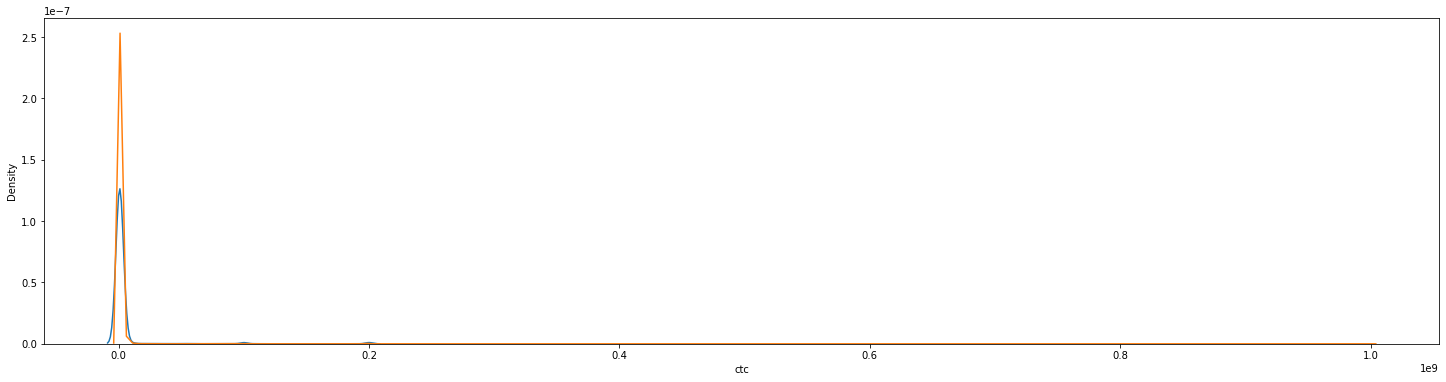

In [191]:
plt.figure(figsize=(25,6))
sns.distplot(df[df['job_position'] == 'Other']['ctc'],hist=False)
sns.distplot(df[df['job_position'].isnull()]['ctc'], hist= False)
plt.show()


In [192]:
df[df['job_position'] == 'Other']['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto                 1058
xzegojo                                    866
eqtoytq                                    618
wgszxkvzn                                  499
fxuqg rxbxnta                              420
                                          ... 
xzaxvz xzonxnhnt ge ntwyzgrgsj qggqptt       1
ywon                                         1
ftvrny xn srgmvr                             1
ena wgbuvzxto                                1
stztojo mxgrgsxwo ucnrna                     1
Name: company_hash, Length: 6083, dtype: int64

In [193]:
df[df['job_position'].isnull()]['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto         3028
xzegojo                           1937
zgn vuurxwvmrt vwwghzn            1380
wgszxkvzn                         1138
zgn vuurxwvmrt                    1064
                                  ... 
mrvwponqvf                           1
uvzvbvd xzw                          1
cgnvqjntwy                           1
svrvdj ftmrxzpo ucn rna xzagqt       1
vzvrgs vza axsxnvr rvmo              1
Name: company_hash, Length: 12310, dtype: int64

In [194]:
df[(df['company_hash'] == 'nvnv wgzohrnvzwj otqcxwto') & df['job_position'].isin(['Other',np.NaN])]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
337,337,nvnv wgzohrnvzwj otqcxwto,b44191ed851a1dff51ae2cf2a393fc6799d045de7c0b01...,2018.0,440000,Other,2021.0
457,457,nvnv wgzohrnvzwj otqcxwto,717718247f219883fbb9158d11274e033130973fa40dbe...,2015.0,870000,Other,2020.0
507,507,nvnv wgzohrnvzwj otqcxwto,bca52d2d543819b12a99e977b790449277dfe8aebb487f...,2020.0,670000,NaN,2020.0
572,572,nvnv wgzohrnvzwj otqcxwto,6cf36267e3c4454dd4fd6ac7da284863529d721eee847f...,2019.0,300000,NaN,2021.0
634,634,nvnv wgzohrnvzwj otqcxwto,8d9a9bd7f4e3b5b3010ffb2afc1f19ceb39f8324214657...,2015.0,600000,Other,2020.0
...,...,...,...,...,...,...,...
205526,206606,nvnv wgzohrnvzwj otqcxwto,f4d553425ea2e09ec720a4527a51fda7dfdb56c0edee95...,2012.0,580000,NaN,2016.0
205609,206689,nvnv wgzohrnvzwj otqcxwto,c045760766c2b3025998099c8d86422c1a7dba37e3459e...,2020.0,330000,NaN,2020.0
205755,206835,nvnv wgzohrnvzwj otqcxwto,b4e3ab7d11b8b107b3048ada94e2ff18e10755691be6c8...,2019.0,740000,NaN,2021.0
205781,206861,nvnv wgzohrnvzwj otqcxwto,9c7572369588ff6c58339ef315b446a039a44ac9a15cbf...,2019.0,672000,NaN,2019.0


In [195]:
# Imputing all Null values as 'None' which is a separate category as 

df['job_position'].fillna('None',inplace=True)

Removing any special characters from 

In [196]:
def job_label(x):
    """ Function to return the clean data"""
    return re.sub('[^A-Za-z0-9 ]+', '', x)

In [197]:
df['job_position'].fillna('None',inplace=True)

In [198]:
df.isnull().sum()

Unnamed: 0           0
company_hash        44
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

#### Company Level Exploration

In [199]:
df['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto             8337
xzegojo                               5381
vbvkgz                                3481
zgn vuurxwvmrt vwwghzn                3411
wgszxkvzn                             3240
                                      ... 
rhmx trtwnqgzxwo                         1
zxn oqxvzvsvq                            1
xm nqvwp ogrhnxgzo                       1
tdutzojv                                 1
gutzntdn ntwyzgrgsxto xzaxv ucnrna       1
Name: company_hash, Length: 37299, dtype: int64

In [200]:
df.isnull().sum()

Unnamed: 0           0
company_hash        44
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

In [201]:
df[df['company_hash'].isnull()]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
1115,1115,NaN,8fe09b732fe2e5b66c14904fd02ff89fb54f458465ac1e...,2022.0,66600000,None,2020.0
2400,2400,NaN,1074b55f02e6fc88596db85854e057c98cb53c038e0d7f...,2018.0,250000,Other,2019.0
3277,3277,NaN,66263f4942b046c67ae6e2570e7825c03792631a0b13f1...,2018.0,500000,Other,2019.0
4205,4205,NaN,6eb55d779699a2ea94f340ab7a58c8ec505e38bbb41214...,2018.0,600000,None,2020.0
4596,4597,NaN,18813fe2a50a45cc02c5b3871c676bd147c80ff0327ee9...,2020.0,300000,None,2021.0
11753,11761,NaN,ea4f735b9357e8086a42bacc1f64b18e98c3dd1ad81f60...,2018.0,300000,None,2021.0
14739,14748,NaN,b4a56d1199bc569aabd30cba8ea7a86fbddc85211453ba...,2013.0,1600000,None,2021.0
18853,18865,NaN,07a60d6e853852471b0963b78a0a3074532572a2580864...,2017.0,700000,FullStack Engineer,2021.0
19466,19478,NaN,07a60d6e853852471b0963b78a0a3074532572a2580864...,2017.0,700000,None,2021.0
22846,22864,NaN,bdce6736cc1d55a909a46aed9e0bfdcd7cd523bfcf9b63...,2010.0,2000000,None,2020.0


In [202]:
df['company_hash'].fillna('Others',inplace=True)

In [203]:
df['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto             8337
xzegojo                               5381
vbvkgz                                3481
zgn vuurxwvmrt vwwghzn                3411
wgszxkvzn                             3240
                                      ... 
rhmx trtwnqgzxwo                         1
zxn oqxvzvsvq                            1
xm nqvwp ogrhnxgzo                       1
tdutzojv                                 1
gutzntdn ntwyzgrgsxto xzaxv ucnrna       1
Name: company_hash, Length: 37300, dtype: int64

In [204]:
df.isnull().sum()

Unnamed: 0           0
company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

##### Organizational Year

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205843 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      205843 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [206]:
df['orgyear'].value_counts()

2018.0    25256
2019.0    23427
2017.0    23239
2016.0    23043
2015.0    20610
          ...  
1981.0        1
1972.0        1
208.0         1
4.0           1
1900.0        1
Name: orgyear, Length: 77, dtype: int64

In [207]:
# df['orgyear'].fillna(2018.0,inplace=True)
# df['orgyear'] = df['orgyear'].astype('int64')

In [208]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['orgyear'].value_counts()

These rows doesn't seem to right. We need to check further before dropping them

In [209]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['company_hash'].value_counts()

In [210]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['job_position'].value_counts()

In [211]:
# df[(df['orgyear'] >= 0) & (df['orgyear'] <= 1900)]['ctc_updated_year'].value_counts()

In [212]:
df.isnull().sum()

Unnamed: 0           0
company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

In [213]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
df['orgyear'] = imputer.fit_transform(np.array(df['orgyear']).reshape(-1,1))

In [214]:
df.isnull().sum()

Unnamed: 0          0
company_hash        0
email_hash          0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
dtype: int64

In [114]:
df['orgyear'].value_counts()

2018.0    25263
2019.0    23434
2017.0    23252
2016.0    23051
2015.0    20613
          ...  
2204.0        1
1973.0        1
1981.0        1
2106.0        1
2101.0        1
Name: orgyear, Length: 89, dtype: int64

All null values are sorted. Let perform a certain level of exploration

### Exploration

In [103]:
df['ctc_updated_year'] = df['ctc_updated_year'].astype('int64')

In [101]:
df['YOE'] = df['ctc_updated_year'] - df['orgyear']

In [104]:
#Filtering out rows where YOE is negative i.e. Employee got CTC update  before joining the Organization
df[~(df['YOE'] < 0)]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YOE
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0,4.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0,1.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0,5.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0,2.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0,2.0
...,...,...,...,...,...,...,...,...
205838,206918,vuurt xzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000,None,2019.0,11.0
205839,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000,None,2020.0,3.0
205840,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000,None,2021.0,0.0
205841,206921,zgn vuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000,None,2019.0,0.0


In [105]:
# Dropping the Unamed Column. 

In [111]:
# 2 years is the average number to get a hike in any industry. Business Context applied. 
def orgyear_imputer(x):
    return x - 2

In [113]:
df[(df['ctc_updated_year'] - df['orgyear']) > 100]['orgyear'] = df['ctc_updated_year'].apply(orgyear_imputer)

In [114]:
df[(df['ctc_updated_year'] - df['orgyear']) > 100]['orgyear']

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015,2000000,Backend Engineer,2020
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019
...,...,...,...,...,...,...
205838,vuurt xzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008,220000,None,2019
205839,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017,500000,None,2020
205840,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021,700000,None,2021
205841,zgn vuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019,5100000,None,2019
